# **Análisis de reseñas de Disneyland Paris**

**Abstracto con Motivación y Audiencia**

Este proyecto se enfoca en analizar reseñas de Disneyland París utilizando técnicas de procesamiento de lenguaje natural (NLP).
Las reseñas en linea tienen una gran influencia en la toma de decisiones, por lo que resulta importante entender cómo los visitantes perciben la experiencia en el parque. Este análisis está orientado a audiencias del sector turístico y de entretenimiento, como gestores de parques temáticos y profesionales de marketing, quienes pueden beneficiarse al alinear la experiencia del cliente con sus expectativas.

**Contexto Comercial y Analítico**

Disneyland París es uno de los destinos turísticos más importantes de Europa, el cual recibe millones de visitantes anuales. Las plataformas de reseñas en línea influyen en la reputación del parque y, por ende, en la decisión de nuevos clientes de visitarlo.
Por otra parte, desde una perspectiva comercial, identificar patrones de satisfacción e insatisfacción permite optimizar las operaciones, aumentar la lealtad de los clientes y mejorar las estrategias de marketing. La aplicación técnicas de NLP a las reseñas proporciona un enfoque basado en datos para medir el sentimiento, identificar temas recurrentes y detectar aspectos críticos en la experiencia de los visitantes.

Las preguntas que guiarán mi análisis serán las siguientes:

1. ¿Qué proporción de las reseñas refleja experiencias positivas o negativas?
Hipótesis: La mayoría de las reseñas son positivas, dado el posicionamiento premium de Disneyland París.

2. ¿Existen palabras o temas específicos que se repiten en las reseñas negativas?
Hipótesis: Problemas relacionados con el tiempo de espera en atracciones y/o los precios.

**Objetivo**

El objetivo de este proyecto es desarrollar un modelo de análisis de sentimientos capaz de clasificar automáticamente las reseñas de Disneyland París como positivas o negativas. Con este modelo, se busca proporcionar información valiosa sobre los aspectos que impactan la experiencia del cliente, permitiendo que los gestores del parque tomen decisiones informadas para mejorar la satisfacción de los visitantes.

# **Lectura de datos**

**Librerias necesarias**

In [1]:
import os
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import numpy as np
import pandas as pd
from pylab import rcParams
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from collections import Counter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Configuración del entorno de Python en Google Colab**

In [2]:
# Primero extraigo mi credencial
! pip install -q kaggle
#https://drive.google.com/file/d/1DUOYQqCZS4ZjtEG4fQFZPKKGePFPoYIg/view?usp=sharing De este enlace me interesa el ID, lo que viene despues del /d/
! gdown --id 1DUOYQqCZS4ZjtEG4fQFZPKKGePFPoYIg # Acá coloco mi ID personal (el de arriba)
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json #con estas lineas verifico la correcta conexión
! kaggle datasets list ##listado de los datasets de Kaggle para verificar la correcta conexión
!kaggle datasets download -d arushchillar/disneyland-reviews #Descarga de la APIs del dataset desde Kaggle (agregar el signo de exclamación)

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DUOYQqCZS4ZjtEG4fQFZPKKGePFPoYIg
To: /content/kaggle.json
100% 76.0/76.0 [00:00<00:00, 296kB/s]
ref                                                              title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset      Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          22236        458  1.0              
muhammadroshaanriaz/students-performance-dataset-cleaned         Students Perf

In [3]:
pd.set_option('display.max_rows', None) #como se descarga un zip, hay que descomprimirlo
!unzip /content/disneyland-reviews.zip

Archive:  /content/disneyland-reviews.zip
  inflating: DisneylandReviews.csv   


**Lectura del corpus**

In [4]:
disney_reviews = pd.read_csv('/content/DisneylandReviews.csv', encoding='latin-1')

**Análisis inicial**

In [5]:
disney_reviews.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


El dataset cuenta con 6 columnas:

-**Review_ID:** Número identificador de la review

-**Rating:** Calificación otorgada por el cliente

-**Year_Month:** Mes y el año de la review

-**Review_Location:** Lugar de donde proviene el cliente

-**Review_Text:** Descripción de la review

-**Branch:** Parque de Disney de donde corresponde la review (Honk Kong, Paris o California).

In [6]:
disney_reviews.shape

(42656, 6)

In [7]:
# Veamos cuántas reseñas tenemos por cada parque
print("\nCantidad de reseñas por parque:")
print(disney_reviews['Branch'].value_counts())


Cantidad de reseñas por parque:
Branch
Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: count, dtype: int64


Se observa que tenemos un total de 19406 reseñas del Disneyland California, 13630 reseñas del Disneyland de Paris y 9620 reseñas del Disneyland de Honk Kong. Por motivos prácticos del manejo de la cantidad de información, se procederá a trabajar sólo con las reseñas del Disneyland de Paris.

In [8]:
# Filtramos sólo las reseñas del Disneyland París
paris_reviews = disney_reviews[disney_reviews['Branch'] == 'Disneyland_Paris']

# Vemos las primeras filas del nuevo DataFrame filtrado
print(paris_reviews.head())

# Confirmamos la cantidad de reseñas que quedaron en el filtro
print(f"Cantidad de reseñas de Disneyland París: {len(paris_reviews)}")


       Review_ID  Rating Year_Month     Reviewer_Location  \
29026  670721950       5     2019-3  United Arab Emirates   
29027  670686565       4     2018-6        United Kingdom   
29028  670606796       5     2019-4        United Kingdom   
29029  670586937       4     2019-4             Australia   
29030  670535589       5    missing                France   

                                             Review_Text            Branch  
29026  We've been to Disneyland Hongkong and Tokyo, s...  Disneyland_Paris  
29027  I went to Disneyland Paris in April 2018 on Ea...  Disneyland_Paris  
29028  What a fantastic place, the queues were decent...  Disneyland_Paris  
29029  We didn't realise it was school holidays when ...  Disneyland_Paris  
29030  A Trip to Disney makes you all warm and fuzzy ...  Disneyland_Paris  
Cantidad de reseñas de Disneyland París: 13630


# **Análisis Exploratorio**

**Análisis de valores nulos:**

In [9]:
print("\nValores faltantes por columna:")
print(paris_reviews.isnull().sum())


Valores faltantes por columna:
Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


No se observan valores nulos.

**Distribución de los ratings:**

In [10]:
paris_reviews.Rating.value_counts()

,count
Rating,
5,6111
4,3564
3,2083
2,1044
1,828


In [11]:
percent_val = 100 * paris_reviews.Rating.value_counts()/paris_reviews.shape[0]
percent_val

,count
Rating,
5,44.834923
4,26.148202
3,15.282465
2,7.659574
1,6.074835


Text(0, 0.5, 'Porcentaje (%)')

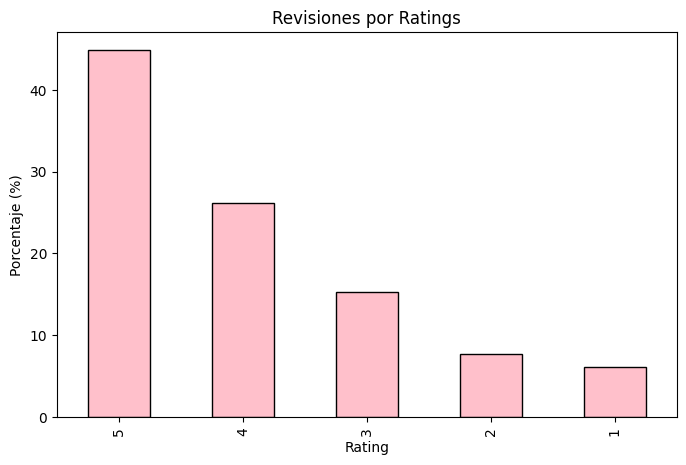

In [12]:
plt.figure(figsize=(8, 5))
percent_val.plot.bar(edgecolor='black', color='pink')
plt.title('Revisiones por Ratings')
plt.xlabel('Rating')
plt.ylabel('Porcentaje (%)')

Vemos un sesgo en los datos, la mayoría de las reviews son positivas.

**Análisis de la Longitud de las Oraciones**

In [13]:
import re
from nltk.stem import WordNetLemmatizer


# Descargamos stopwords y WordNet

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() # Lematizamos (reducimos cada palabra a su forma base)
stop_words = set(stopwords.words('english'))

# Limpiamos y preprocesamos el texto
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Eliminamos HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminamos puntuación
    tokens = [lemmatizer.lemmatize(word.lower()) for word in text.split() # Convertimos mayúsculas a minúsculas y tokenizamos
              if word.lower() not in stop_words] # Eliminamos stopwords
    return ' '.join(tokens)

# Aplicamos la función de preprocesamiento solo en la columna review_text
paris_reviews['cleaned_review'] = paris_reviews['Review_Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-13-5c95ef2c41a5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_reviews['cleaned_review'] = paris_reviews['Review_Text'].apply(preprocess_text)


Text(0, 0.5, 'Frecuencia')

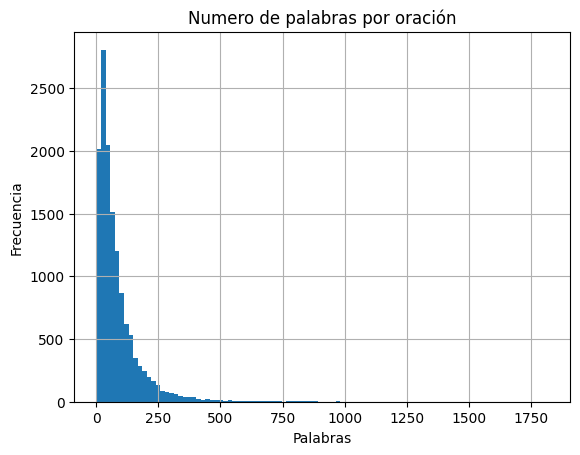

In [14]:
#Numero de palabras por oración
words_per_review = paris_reviews.cleaned_review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por oración')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [15]:
words_per_review.mean()

86.46610418195158

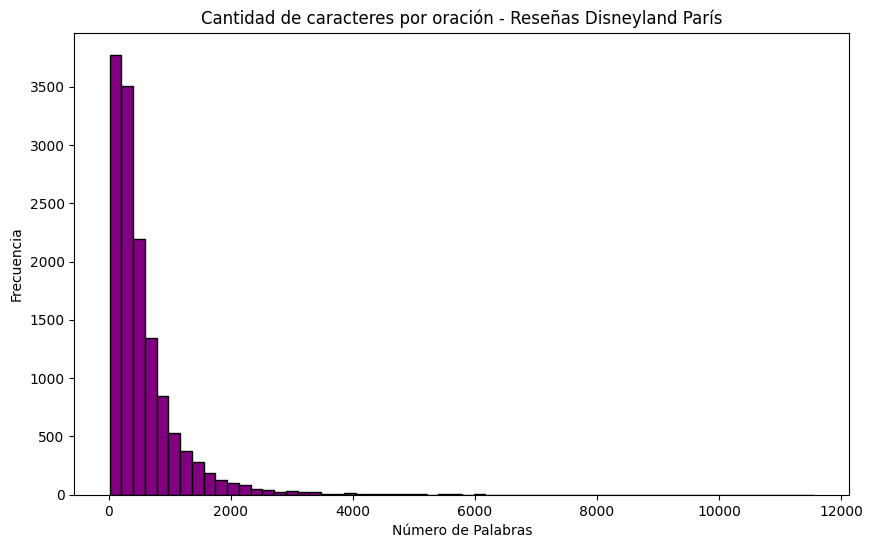

In [16]:
# Cantidad de caracteres por oración
sentence_lengths = [len(sentence) for sentence in paris_reviews['cleaned_review']]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=60, edgecolor='black', color='purple')
plt.title('Cantidad de caracteres por oración - Reseñas Disneyland París')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()


**Análisis de la Frecuencia de Palabras**

In [17]:
# Contamos las palabras en nuestro texto ya procesado
all_words = ' '.join(paris_reviews['cleaned_review']).split()
word_counts = Counter(all_words)

# Convertimos el conteo a un DataFrame para facilitar el análisis
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

# Mostramos las 20 palabras más comunes
print(word_counts_df.head(20))


           Word  Frequency
62         park      23351
38         ride      19926
17       disney      16107
26         time      14604
13          day      13302
59          get       9436
5           one       8959
74        queue       8695
1    disneyland       8225
97           go       8019
96        would       6738
87         food       6590
44        paris       6224
196        good       6055
242       great       5732
259       child       5401
153         kid       5376
41         show       5344
482      really       5308
104        year       5186


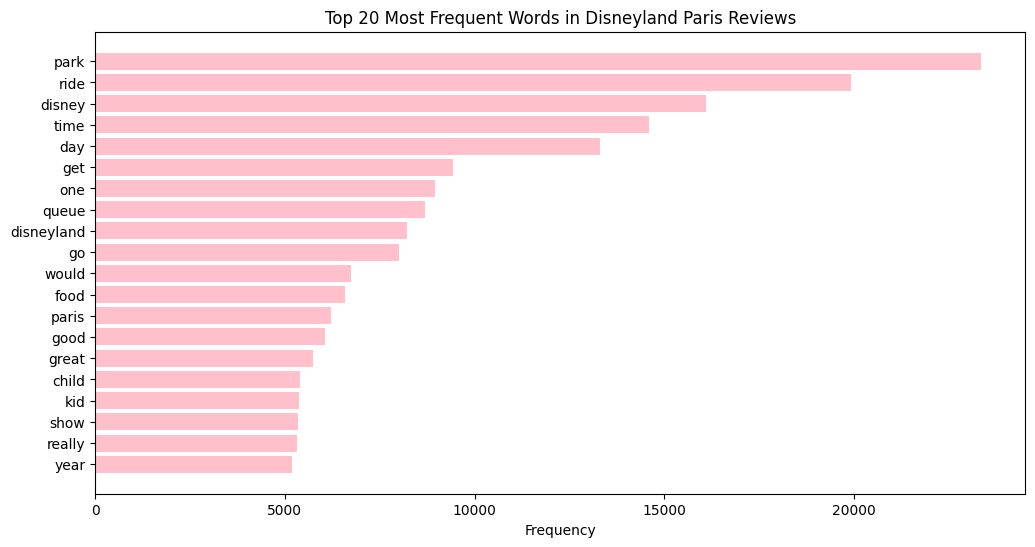

In [18]:
# Gráfico de barras de las 20 palabras más comunes
top_words = word_counts_df.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_words['Word'], top_words['Frequency'], color='pink')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words in Disneyland Paris Reviews')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra más frecuente en la parte superior
plt.show()

**Como park, disney, disneyland y paris son palabras que no aportan a la review, también las sacamos.**

          Word  Frequency
38        ride      19926
26        time      14604
13         day      13302
59         get       9436
5          one       8959
74       queue       8695
97          go       8019
96       would       6738
87        food       6590
196       good       6055
242      great       5732
259      child       5401
153        kid       5376
41        show       5344
482     really       5308
104       year       5186
102      place       5079
624  character       4967
18       hotel       4954
116     parade       4888


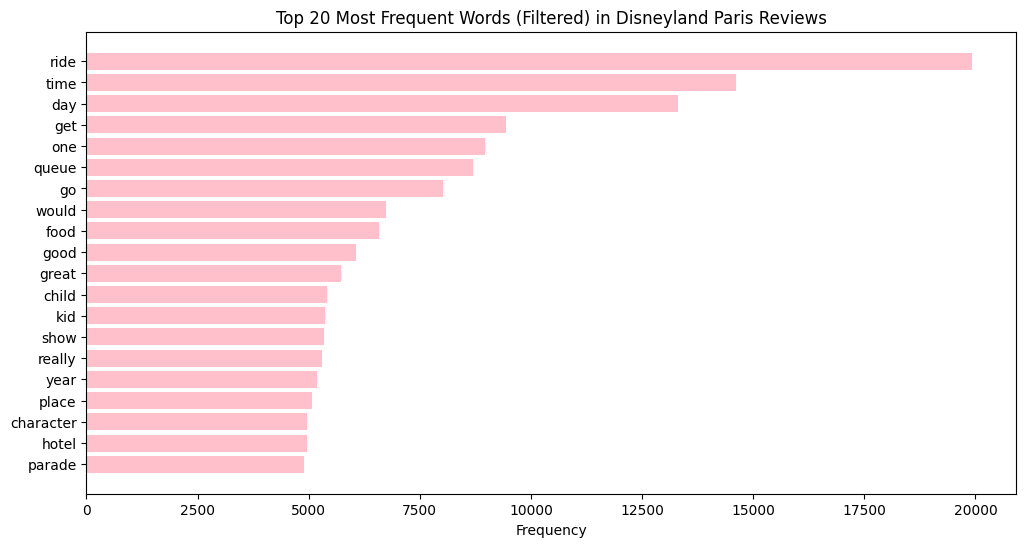

In [19]:
# Lista de palabras a eliminar
stop_words_custom = {'disney', 'park', 'disneyland', 'paris'}

# Filtramos el DataFrame para eliminar las palabras no deseadas
filtered_word_counts_df = word_counts_df[~word_counts_df['Word'].isin(stop_words_custom)]

# Mostramos las 20 palabras más comunes después de la filtración
print(filtered_word_counts_df.head(20))

# Graficamos las 20 palabras más comunes después de la filtración
top_filtered_words = filtered_word_counts_df.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_filtered_words['Word'], top_filtered_words['Frequency'], color='pink')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words (Filtered) in Disneyland Paris Reviews')
plt.gca().invert_yaxis()  # Invertir el eje y
plt.show()


**Análisis de las Partes del Discurso (POS)**

Las 10 partes del discurso más comunes: [('NOUN', 13621), ('PROPN', 12347), ('SPACE', 6741), ('DET', 2847), ('PRON', 2705), ('X', 1868), ('VERB', 1644), ('CCONJ', 1187), ('NUM', 438), ('ADP', 422)]


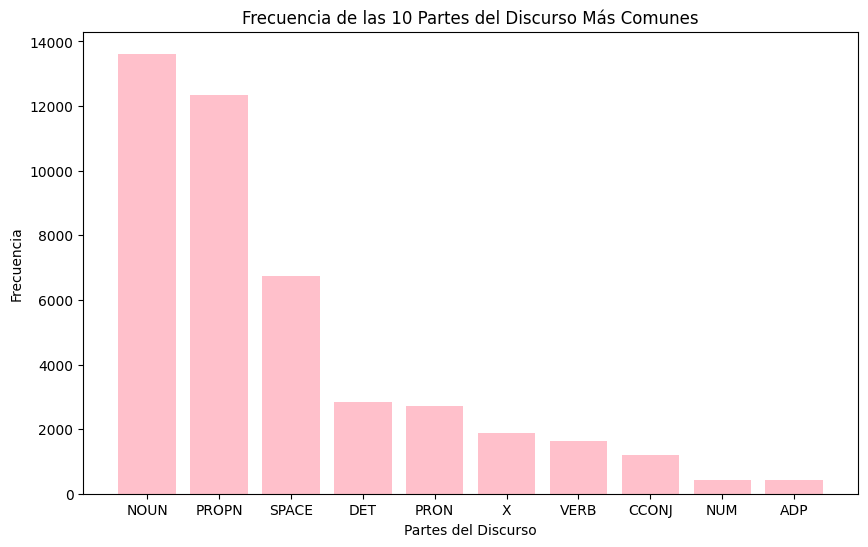

In [20]:
# Cargamos el modelo de spaCy en inglés
nlp = spacy.load('en_core_web_sm')
# Función para obtener las partes del discurso (POS)
def pos_tagging(sentence):
    doc = nlp(" ".join(sentence))
    return [(token.text, token.pos_) for token in doc]

# Aplicamos POS tagging (sólo con 100 reviews porque sino tarda mucho en ejecutar)
pos_tagged_corpus = [pos_tagging(sentence) for sentence in paris_reviews['cleaned_review'][:100]]

# Contamos la frecuencia de las partes del discurso
pos_counts = Counter([pos for sentence in pos_tagged_corpus for _, pos in sentence])

# Mostramos las partes del discurso más comunes
most_common_pos = pos_counts.most_common(10)
print("Las 10 partes del discurso más comunes:", most_common_pos)

# Gráfico de las partes del discurso más comunes
pos, counts = zip(*most_common_pos)
plt.figure(figsize=(10, 6))
plt.bar(pos, counts, color='pink')
plt.title('Frecuencia de las 10 Partes del Discurso Más Comunes')
plt.xlabel('Partes del Discurso')
plt.ylabel('Frecuencia')
plt.show()

**Análisis de la Distribución de Longitud de Palabras**

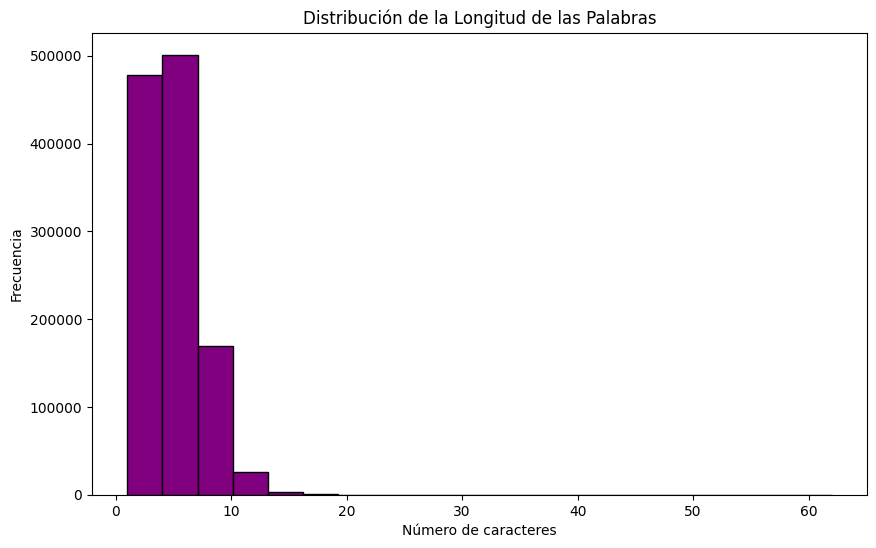

In [21]:
# Longitud de las palabras
word_lengths = [len(word) for word in all_words]

plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=20, edgecolor='black', color='purple')
plt.title('Distribución de la Longitud de las Palabras')
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.show()

La mayor cantidad de palabras presentes en el corpus tiene menos de 10 caracteres.

**Distribución de la Frecuencia de Palabras Únicas**

Número de palabras únicas en el corpus: 42217


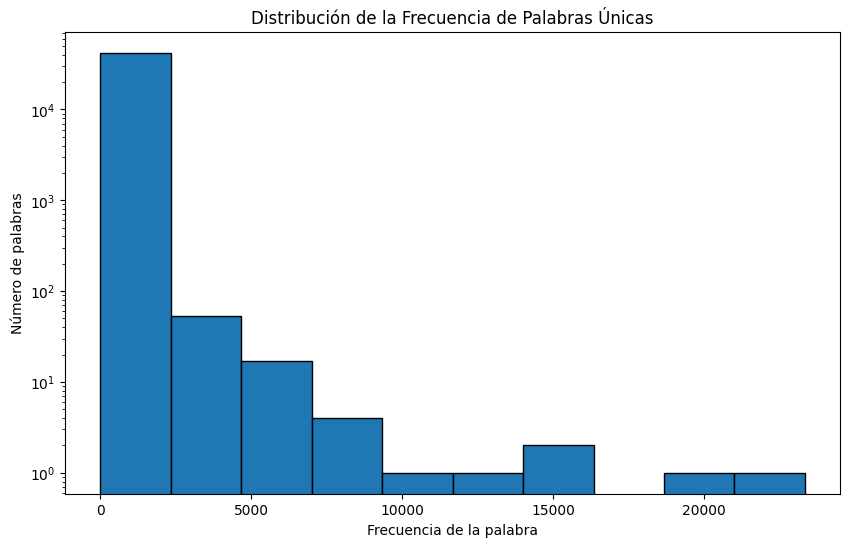

In [22]:
# Número de palabras únicas
unique_words = set(all_words)
num_unique_words = len(unique_words)
print(f"Número de palabras únicas en el corpus: {num_unique_words}")
word_freq = Counter(all_words)
# Distribución de frecuencia de palabras únicas
unique_word_freq = [word_freq[word] for word in unique_words]

plt.figure(figsize=(10, 6))
plt.hist(unique_word_freq, bins=10, edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas')
plt.xlabel('Frecuencia de la palabra')
plt.ylabel('Número de palabras')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

**Análisis de N-gramas**

In [23]:
# Creamos el CountVectorizer con las stop_words definidas

vectorizer = CountVectorizer(ngram_range=(2,2)) # 2,2 funciona para crear bigramas. Podes modificar el rango de valores para crear trigramas(3,3).

# Transformamos el texto de la columna ‘descripción’ en n-gramas

X = vectorizer.fit_transform(paris_reviews['cleaned_review'])

# Extraemos los n-gramas y sus frecuencias

n_grams = vectorizer.get_feature_names_out()

frequencies = X.toarray().sum(axis=0)

# Creamos un diccionario con los n-gramas y sus frecuencias

n_grams_freq = dict(zip(n_grams, frequencies))

# Convertimos el diccionario en un DataFrame

df_n_grams = pd.DataFrame(n_grams_freq.items(), columns=['n_gram', 'frecuencia'])

# Ordenamos el DataFrame en base a la columna de ‘frecuencia’ en orden descendente

df_n_grams = df_n_grams.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# Mostramos el DataFrame ordenado

df_n_grams.head(10)

,n_gram,frecuencia
0,disneyland paris,2955
1,year old,1911
2,fast pas,1907
3,space mountain,1291
4,disney park,1258
5,thunder mountain,1256
6,disney studio,995
7,disneyland park,984
8,theme park,956
9,go back,936


**Análisis de la Diversidad Léxica**

In [24]:
# Número total de palabras en el corpus
num_words = sum(len(sentence) for sentence in paris_reviews['cleaned_review'])
print(f"Número total de palabras en el corpus: {num_words}")

# Diversidad léxica
lexical_diversity = num_unique_words / num_words
print(f"Diversidad léxica: {lexical_diversity:.4f}")

Número total de palabras en el corpus: 7600309
Diversidad léxica: 0.0056


**La diversidad léxica es baja.**

**Visualización de Palabras con Word Cloud**

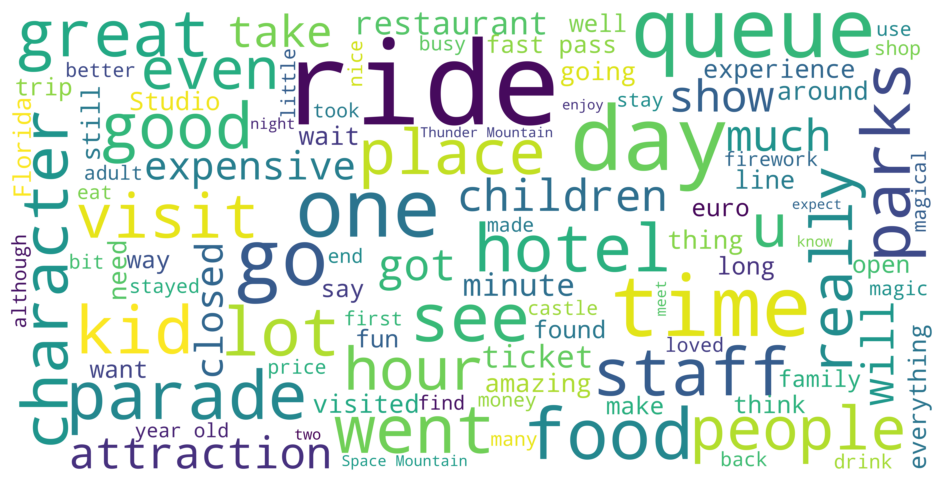

In [25]:
# Combinamos las reseñas en un solo texto
word_cloud_text = ''.join(paris_reviews.Review_Text)

# Definimos las palabras a excluir
custom_stopwords = {'disney', 'disneyland', 'paris', 'park'}

# Combinamos estas con las stopwords predefinidas
stopwords = STOPWORDS.union(custom_stopwords)

# Generamos la nube de palabras
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    stopwords=stopwords  # Agregamos aca el conjunto de stopwords
).generate(word_cloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


**El wordcloud muestra que muchas reviews hablan de la comida, los shows, y las colas de espera.**

# **Estandarización del ranking para el análisis de sentimientos**

Para simplificar el análisis, convertiremos todos los ratings en valores binarios según las siguientes reglas:

-ratings de 4 o 5 seran convertidos a 1 (positivo)

-ratings de 1 o 2 seran convertidos a 0 (negativo)

-ratings de 3 seran removidos del analisis

In [26]:
paris_reviews['Rating'] = np.where(paris_reviews.Rating > 3, 1, 0) #Consideramos como 1 las reviews mayores a 3, sino se considera como 0
paris_reviews['Rating'].value_counts()

<ipython-input-26-d5378eb3ceec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_reviews['Rating'] = np.where(paris_reviews.Rating > 3, 1, 0) #Consideramos como 1 las reviews mayores a 3, sino se considera como 0


,count
Rating,
1,9675
0,3955


In [27]:
# removiendo neutrales
paris_reviews = paris_reviews[paris_reviews.Rating != 3]

Text(0, 0.5, 'Frecuencia')

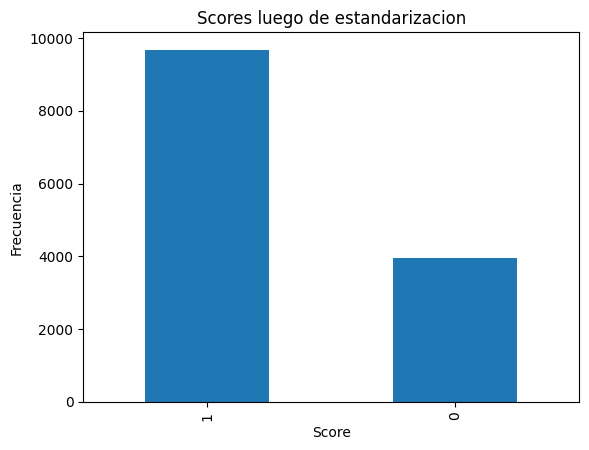

In [29]:
paris_reviews.Rating.value_counts().plot.bar()
plt.title('Scores luego de estandarizacion')
plt.xlabel('Score')
plt.ylabel('Frecuencia')

# **Preprocesamiento del Texto**

*Tokenización:*

Tokenizar el texto en palabras, frases o párrafos según sea necesario.

*Limpieza del Texto:*

Convertir a minusculas, eliminar caracteres no deseados, stopwords, lematización, y stemming.

*Análisis Léxico y Morfológico:*

Identificación de partes del discurso (POS tagging) y análisis morfológico.

In [33]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Descargamos recursos de NLTK si aún no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')

# Inicializamos lematizador y lista de stopwords en inglés
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función para preprocesar el texto
def preprocess_text(text):
    # 1. Eliminar HTML
    text = re.sub(r'<.*?>', '', text)
    # 2. Eliminar caracteres especiales y puntuación
    text = re.sub(r'[^\w\s]', '', text)
    # 3. Convertir a minúsculas y tokenizar
    tokens = text.lower().split()
    # 4. Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # 5. Unir tokens en un solo string limpio
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Aplicamos la función de preprocesamiento a la columna de texto
paris_reviews['cleaned']= paris_reviews['Review_Text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
#Veamos si funciono
paris_reviews[['Review_Text', 'cleaned']].head(10)

,Review_Text,cleaned
29026,"We've been to Disneyland Hongkong and Tokyo, s...",weve disneyland hongkong tokyo far one best lo...
29027,I went to Disneyland Paris in April 2018 on Ea...,went disneyland paris april 2018 easter weeken...
29028,"What a fantastic place, the queues were decent...",fantastic place queue decent best time year go...
29029,We didn't realise it was school holidays when ...,didnt realise school holiday went consequently...
29030,A Trip to Disney makes you all warm and fuzzy ...,trip disney make warm fuzzy actual kid big u o...
29031,Such a magical experience. I recommend making ...,magical experience recommend making u free fas...
29032,My boyfriend took me here for my birthday this...,boyfriend took birthday year god he done great...
29033,Everything here is just amazing. Take your own...,everything amazing take lunch save time money ...
29034,"We booked tickets on line for Disneyland, this...",booked ticket line disneyland something recomm...
29035,"The park is as I expected just brilliant, so e...",park expected brilliant exciting kid magicalbu...


**Análisis Sintáctico**

*Parsing:*

Construir árboles sintácticos para las oraciones en el corpus.

*Dependencia Sintáctica:*

Análisis de dependencias para entender las relaciones gramaticales entre palabras.

In [35]:
# Función para analizar dependencias y relaciones de cada reseña
def parse_dependencies(text):
    doc = nlp(text)
    # Extraer tokens con su tipo de dependencia y el token cabeza (head)
    parsed_data = [(token.text, token.dep_, token.head.text) for token in doc]
    return parsed_data

# Tomamos una muestra de las primeras 100 reseñas de la columna preprocesada
sample_reviews = paris_reviews['cleaned'].head(100)

# Aplicamos la función de parsing solo a esta muestra
sample_reviews_dependencies = sample_reviews.apply(parse_dependencies)

# Mostramos un ejemplo de las dependencias en las primeras 100 reseñas
print(sample_reviews_dependencies.head())


29026    [(we, nsubj, ve), (ve, aux, save), (disneyland...
29027    [(went, ROOT, went), (disneyland, compound, pa...
29028    [(fantastic, amod, queue), (place, compound, q...
29029    [(did, aux, realise), (nt, neg, realise), (rea...
29030    [(trip, compound, disney), (disney, nsubj, mak...
Name: cleaned, dtype: object


**we, nsubj, ve:** "we" es el sujeto nominal (nsubj) de "ve" (que es "have" abreviado pero como previamente quitamos comillas, quedó como "ve").

**ve, aux, save:** "ve" es un verbo auxiliar (aux) en relación con "save".

**fantastic, amod, queue:** "fantastic" es un adjetivo modificador de "queue".

## **Modelo de regresión logística basado en Bag of Word**

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score


X = paris_reviews['cleaned']
y = paris_reviews['Rating']

# Dividimos en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos un pipeline de BoW con Naive Bayes
pipeline = make_pipeline(
    CountVectorizer(ngram_range=(1, 4)),
    LogisticRegression(max_iter=800)        # Clasificador lr
)

# Entrenamos el modelo
pipeline.fit(X_train, y_train)

# Predecimos en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluamos el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8584005869405723
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       801
           1       0.87      0.93      0.90      1925

    accuracy                           0.86      2726
   macro avg       0.84      0.81      0.82      2726
weighted avg       0.86      0.86      0.85      2726



In [38]:
# Definimos frases de prueba para probar el modelo

test_phrases = [
    'The experience was incredible; I had a better time than I imagined.',
    'The park was overcrowded, and the lines were endless. It was very frustrating.',
    'What a magical day! Everything was perfect, and the characters were wonderful!',
    'I have never seen a place so disorganized; it was a huge disappointment.',
    'The fireworks at the end of the day were simply breathtaking.',
    'My family enjoyed every moment. We’ll definitely be back soon!',
    'The food was overpriced and of poor quality.',
    'The rides were thrilling and well-maintained. I loved it!',
    'The whole trip was a disaster; I wouldn’t recommend this park to anyone.',
    'The live shows were beautiful and very entertaining.',
    'The facilities were dirty and poorly maintained, which was unpleasant.',
    'The kids were fascinated; it was a dream come true for them.',
    'The wait time was excessively long and frustrating.',
    'The prices are too high for the quality of food offered.',
    'There were too many technical issues on the rides, which ruined the day.',
    'The ticket price was not worth it; the experience was boring.',
    'I had a horrible experience and left feeling very disappointed.',
    'The Disney characters were charming and made the day special.',
    'I was disappointed by the lack of organization and the long wait times.'
]
# Probamos el modelo con diferentes frases y mostrar las predicciones
for phrase in test_phrases:
    prediction = pipeline.predict([phrase])
    print(f"Phrase: {phrase}")
    print(f"Prediction: {prediction[0]}")
    print('-' * 50)

Phrase: The experience was incredible; I had a better time than I imagined.
Prediction: 1
--------------------------------------------------
Phrase: The park was overcrowded, and the lines were endless. It was very frustrating.
Prediction: 1
--------------------------------------------------
Phrase: What a magical day! Everything was perfect, and the characters were wonderful!
Prediction: 1
--------------------------------------------------
Phrase: I have never seen a place so disorganized; it was a huge disappointment.
Prediction: 1
--------------------------------------------------
Phrase: The fireworks at the end of the day were simply breathtaking.
Prediction: 1
--------------------------------------------------
Phrase: My family enjoyed every moment. We’ll definitely be back soon!
Prediction: 1
--------------------------------------------------
Phrase: The food was overpriced and of poor quality.
Prediction: 1
--------------------------------------------------
Phrase: The rides we

**Los resultados del modelo no son tan buenos, considerando que las predicciones de algunas frases no fueron correctas. Realizaremos un balanceo de clases para ver si el modelo funciona mejor.**

In [41]:
from imblearn.under_sampling import RandomUnderSampler

X = paris_reviews[['cleaned']]  # Cambiamos a DataFrame
y = paris_reviews['Rating']

# Aplicamos el submuestreo de la clase mayoritaria
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Dividimos los datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled['cleaned'], y_resampled, test_size=0.2, random_state=42)

# Creamos un pipeline de BoW con Logistic Regression
pipeline = make_pipeline(
    CountVectorizer(ngram_range=(1, 4)),
    LogisticRegression(max_iter=800)
)

# Entrenamos el modelo con los datos balanceados
pipeline.fit(X_train, y_train)

# Predecimos en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluamos el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8394437420986094
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       812
           1       0.82      0.86      0.84       770

    accuracy                           0.84      1582
   macro avg       0.84      0.84      0.84      1582
weighted avg       0.84      0.84      0.84      1582



**Comparando los dos modelos (antes y después del balanceo de clases), el primero alcanzó una precisión global mayor que el segundo (85.8% vs 84%), con un mejor desempeño en la clasificación de reseñas positivas respecto a las negativas. Sin embargo, el segundo modelo tuvo una precisión global pero mostró un balance más equitativo entre ambas clases, con f1-scores similares de 0.84 para ambas y una distribución más uniforme en términos de precision y recall. Esto sugiere que, aunque el primer modelo es más preciso en general, el segundo ofrece una mejor estabilidad y equidad en la clasificación de las clases.**

In [42]:
# Definimos frases de prueba

test_phrases = [
    'The experience was incredible; I had a better time than I imagined.',
    'The park was overcrowded, and the lines were endless. It was very frustrating.',
    'What a magical day! Everything was perfect, and the characters were wonderful!',
    'I have never seen a place so disorganized; it was a huge disappointment.',
    'The fireworks at the end of the day were simply breathtaking.',
    'My family enjoyed every moment. We’ll definitely be back soon!',
    'The food was overpriced and of poor quality.',
    'The rides were thrilling and well-maintained. I loved it!',
    'The whole trip was a disaster; I wouldn’t recommend this park to anyone.',
    'The live shows were beautiful and very entertaining.',
    'The facilities were dirty and poorly maintained, which was unpleasant.',
    'The kids were fascinated; it was a dream come true for them.',
    'The wait time was excessively long and frustrating.',
    'The prices are too high for the quality of food offered.',
    'There were too many technical issues on the rides, which ruined the day.',
    'The ticket price was not worth it; the experience was boring.',
    'I had a horrible experience and left feeling very disappointed.',
    'The Disney characters were charming and made the day special.',
    'I was disappointed by the lack of organization and the long wait times.'
]
# Probamos el modelo con diferentes frases y mostramos las predicciones
for phrase in test_phrases:
    prediction = pipeline.predict([phrase])
    print(f"Phrase: {phrase}")
    print(f"Prediction: {prediction[0]}")
    print('-' * 50)

Phrase: The experience was incredible; I had a better time than I imagined.
Prediction: 1
--------------------------------------------------
Phrase: The park was overcrowded, and the lines were endless. It was very frustrating.
Prediction: 1
--------------------------------------------------
Phrase: What a magical day! Everything was perfect, and the characters were wonderful!
Prediction: 1
--------------------------------------------------
Phrase: I have never seen a place so disorganized; it was a huge disappointment.
Prediction: 0
--------------------------------------------------
Phrase: The fireworks at the end of the day were simply breathtaking.
Prediction: 1
--------------------------------------------------
Phrase: My family enjoyed every moment. We’ll definitely be back soon!
Prediction: 1
--------------------------------------------------
Phrase: The food was overpriced and of poor quality.
Prediction: 0
--------------------------------------------------
Phrase: The rides we

**El modelo de regresión logística basado en la representación Bag of Words, luego de haberse aplicado un submuestreo de la clase mayoritaria ha mejorado la precisión en la clasificación de reseñas de Disneyland París, especialmente en el reconocimiento de reseñas negativas, lo cual era un desafío debido al desequilibrio de clases.**

## **Modelo de regresión logística basado en Tf-IDF**

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer  # Usamos TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

X = paris_reviews[['cleaned']] #Cambiamos a dataframe
y = paris_reviews['Rating']

# Aplicamos el submuestreo de la clase mayoritaria
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Dividimos los datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled['cleaned'], y_resampled, test_size=0.2, random_state=42)

# Creamos un pipeline de TF-IDF con Logistic Regression
pipeline_tf = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 4)),  # Usamos TfidfVectorizer
    LogisticRegression(max_iter=800)
)

# Entrenamos el modelo con los datos balanceados
pipeline_tf.fit(X_train, y_train)

# Predecimos en el conjunto de prueba
y_pred = pipeline_tf.predict(X_test)

# Evaluamos el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8476611883691529
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       812
           1       0.88      0.80      0.84       770

    accuracy                           0.85      1582
   macro avg       0.85      0.85      0.85      1582
weighted avg       0.85      0.85      0.85      1582



In [44]:
# Probamos el modelo con diferentes frases y mostramos las predicciones
for phrase in test_phrases:
    prediction = pipeline_tf.predict([phrase])
    print(f"Phrase: {phrase}")
    print(f"Prediction: {prediction[0]}")
    print('-' * 50)

Phrase: The experience was incredible; I had a better time than I imagined.
Prediction: 1
--------------------------------------------------
Phrase: The park was overcrowded, and the lines were endless. It was very frustrating.
Prediction: 0
--------------------------------------------------
Phrase: What a magical day! Everything was perfect, and the characters were wonderful!
Prediction: 1
--------------------------------------------------
Phrase: I have never seen a place so disorganized; it was a huge disappointment.
Prediction: 0
--------------------------------------------------
Phrase: The fireworks at the end of the day were simply breathtaking.
Prediction: 1
--------------------------------------------------
Phrase: My family enjoyed every moment. We’ll definitely be back soon!
Prediction: 1
--------------------------------------------------
Phrase: The food was overpriced and of poor quality.
Prediction: 0
--------------------------------------------------
Phrase: The rides we

**Comparando los resultados obtenidos con TF-IDF y Bag of Words, se observó que el modelo con TF-IDF superó al modelo basado en Bag of Words en términos de precisión global (84.7% frente a 83.9%). Además, TF-IDF mejoró el desempeño en la clasificación de reseñas negativas, logrando un recall del 89%, frente al 82% de Bag of Words, lo que indica una mejor capacidad para identificar reseñas negativas. Sin embargo, Bag of Words tuvo un mejor recall para reseñas positivas (86% frente al 80% de TF-IDF), lo que sugiere que Bag of Words puede ser más efectivo en identificar reseñas positivas, aunque su desempeño global fue más bajo. Considerando que TF-IDF demostró ser más equilibrado y robusto, especialmente en el manejo de reseñas negativas, resulta ser una opción más efectiva.**

## Una alternativa: Modelo de Random Forest basado en TF-IDF

In [45]:
X = paris_reviews[['cleaned']]
y = paris_reviews['Rating']

# Aplicamos el submuestreo de la clase mayoritaria
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Dividimos los datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled['cleaned'], y_resampled, test_size=0.2, random_state=42)

# Creamos un pipeline de TF-IDF con RandomForest
pipeline_rf = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 4)),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Entrenamos el modelo con los datos balanceados
pipeline_rf.fit(X_train, y_train)

# Predecimos en el conjunto de prueba
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluamos el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.793299620733249
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       812
           1       0.73      0.91      0.81       770

    accuracy                           0.79      1582
   macro avg       0.81      0.80      0.79      1582
weighted avg       0.81      0.79      0.79      1582



**El modelo Random Forest mostró un rendimiento inferior al modelo con TF-IDF, superándolo en casi todas las métricas, especialmente en precisión y f1-score, tanto para la clase negativa como para la positiva, lo que lo hace más equilibrado y efectivo. Random Forest mostró un recall bajo para la clase negativa (68%), lo que sugiere que el modelo podría estar clasificado muchas reseñas negativas como positivas, perdiendo información importante. En conclusión, TF-IDF parece ser el modelo más robusto.**

## Optimización del modelo de regresión logística basado en TF-IDF

In [46]:
from sklearn.model_selection import GridSearchCV

X = paris_reviews[['cleaned']]  # Cambiamos a DataFrame
y = paris_reviews['Rating']

# Aplicamos el submuestreo de la clase mayoritaria
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Dividimos los datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled['cleaned'], y_resampled, test_size=0.2, random_state=42)

# Creamos el pipeline con TfidfVectorizer y LogisticRegression
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 4)),
    LogisticRegression(random_state=42)
)

# Definimos los hiperparámetros a ajustar
param_grid = {
    'logisticregression__C': [1, 10],            # Solo dos valores de C porque sino tarda mucho en ejecutar
    'logisticregression__solver': ['liblinear'],  # Solo un solver
    'logisticregression__max_iter': [200]        # Solo una opción de max_iter
}

# Creamos el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Entrenamos el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Vemos los mejores parámetros encontrados
print("Best Parameters: ", grid_search.best_params_)

# Evaluamos el modelo con los mejores parámetros
y_pred = grid_search.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters:  {'logisticregression__C': 10, 'logisticregression__max_iter': 200, 'logisticregression__solver': 'liblinear'}
Accuracy: 0.854614412136536
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       812
           1       0.87      0.83      0.85       770

    accuracy                           0.85      1582
   macro avg       0.86      0.85      0.85      1582
weighted avg       0.86      0.85      0.85      1582



**Los resultados del ajuste de hiperparámetros fueron buenos, logrando una ligera mejora en accuracy, subiendo de un 0.839 a 0.854. Además, el f1-score y el recall para ambas clases (positiva y negativa) mostraron mejoras en equilibrio.**

# **Conclusiones Finales**

El objetivo de este proyecto fue desarrollar un modelo de análisis de sentimientos capaz de clasificar automáticamente las reseñas de Disneyland París como positivas o negativas, con el fin de proporcionar información valiosa sobre los aspectos que impactan la experiencia del cliente. Se exploraron y probaron diversas técnicas: comenzamos con un modelo de **Regresión Logística** utilizando la técnica de **Bag of Words**, y luego probamos la representación de texto mediante **TF-IDF**. **Este último demostró ser más eficaz** para capturar la relevancia de las palabras dentro del contexto de las reseñas, lo que resultó en un rendimiento superior en comparación con el modelo inicial. Como alternativa, se probó el modelo de **Random Forest**, pero su **rendimiento** fue **inferior**.

También se aplicó un ajuste de hiperparámetros.

**En conclusión, el proyecto ha cumplido con su objetivo principal de desarrollar un modelo de análisis de sentimientos. A futuro, podrían explorarse enfoques más avanzados, como el uso de modelos de deep learning o representaciones semánticas más sofisticadas, para mejorar aún más la precisión y la capacidad de predicción del modelo.**